# ZIDAS 2021: Python primer

This is a notebook demonstrating the possibilities offered by Python in the frame of bioimage processing.

## Step by step

### Importing packages

Just like Fiji has plugins, Python has packages. You can easily install them with ```conda``` and ```pip``` commands. Then, whenever you need a function of a package, you need to import it.

Usually, functions are grouped into sub-groups. For example, in the package ```skimage``` all filtering functions are grouped in the ```filters``` sub-group (or sub-module) and you use a "dot-notation", e.g. ```skimage.filters.gaussian``` to call them.

In [1]:
import skimage.io
import skimage.filters
from microfilm.microplot import microshow, Micropanel
import numpy as np
import matplotlib.pyplot as plt

### Set variables

Here se set important variables for our pipeline, e.g. whether we first need to filter our image or not.

In [2]:
do_median = True

### Import image

Here we import an image and have a look at it. We also create a variable that contains only the blue channel (nuclei). The images are taken from the [Human Cell Atlas](https://www.proteinatlas.org/humanproteome/cell).

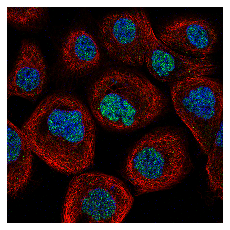

In [3]:
image = skimage.io.imread('24138_196_F7_2.tif')
im_nuclei = image[:,:,2]
microshow(np.rollaxis(image,2,0));

### Filtering

To improve the segmentation via thresholding, we first median filter the image:

In [4]:
if do_median:
    im_nuclei = skimage.filters.median(
        im_nuclei, skimage.morphology.disk(radius=5))

### Thresholding and labelling

We then use the Li thresholding method to create a binary image and then label this binary image to find connected regions.

In [5]:
# Threshold image
im_th = im_nuclei > skimage.filters.threshold_li(im_nuclei)

# Identify nuclei
im_labels = skimage.measure.label(im_th)

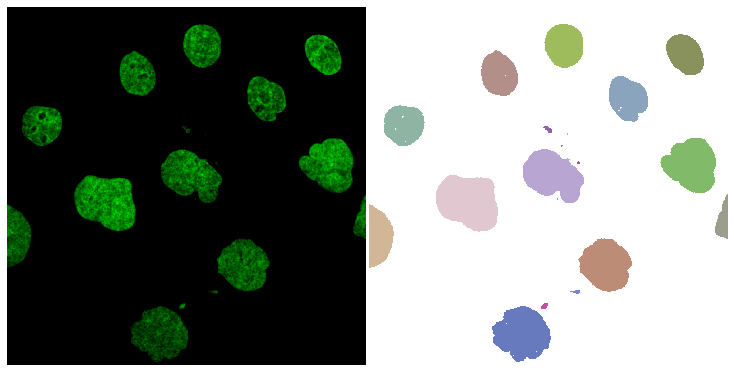

In [6]:
panel = Micropanel(1,2)
panel.add_element([0,0], microshow(im_nuclei, cmaps=['pure_green'], ax=panel.ax[0,0]));
panel.add_element([0,1], microshow(im_labels.astype(np.uint16), cmaps=['segmentation'], ax=panel.ax[0,1]));

### Properties

We can  now analyze the properties of the regions using the ```skimage.measure.regionprops_table``` function which does the same work as the "Analyze Particles" function of Fiji:

In [7]:
props = skimage.measure.regionprops_table(
    label_image=im_labels,
    intensity_image=image[:,:,1],
    properties=('label','area','mean_intensity'))

### Postprocessing

Finally we can do some post-processing e.g. by looking at a histograme of nuclei sizes:

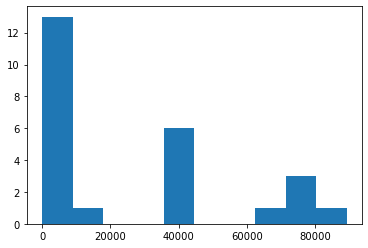

In [8]:
plt.hist(props['area']);

We see that we have a lot of isolated pixels that we should remove. We can filter our result by using logical indexing in numpy:

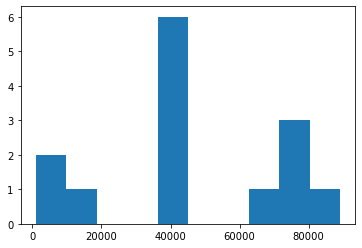

In [9]:
props_clean = props['area'][props['area'] > 1000]
plt.hist(props_clean);

## Complete routine

In [10]:
# set variables
do_median = True

# Open image
image = skimage.io.imread('24138_196_F7_2.tif')

# Extract channel
im_nuclei = image[:,:,2]

# Select nuclei (DAPI) and median filter
if do_median:
    im_nuclei = skimage.filters.median(
        im_nuclei, skimage.morphology.disk(radius=5))

# Threshold image
im_th = im_nuclei > skimage.filters.threshold_li(im_nuclei)

# Identify nuclei
im_labels = skimage.measure.label(im_th)

# Measure mean intensity and size in green
props = skimage.measure.regionprops_table(
    label_image=im_labels,
    intensity_image=image[:,:,1],
    properties=('label','area','mean_intensity'))

# remove small elements
props_clean = props['area'][props['area'] > 1000]

## A more advanced example

Working directly in Python gives direct access to the latest developements, especially in Machine and Deep Learning. As an example, we show here how nuclei can be segmented via [cellpose](), a generalistic deep learning based cell and nuceli segmentation software.

First we load the necessary package from Cellpose:

In [11]:
from cellpose.models import Cellpose

2021-09-28 21:36:40,013 [INFO] WRITING LOG OUTPUT TO /Users/gw18g940/.cellpose/run.log


Then we instantiate (or load) a specific model. Here we want a model of nuclei.

In [12]:
model = Cellpose(model_type='nuclei')

2021-09-28 21:36:40,060 [INFO] >>>> using CPU


Now we can run the segmentation. We just have to pass the image to be segmented to the ```eval``` method od the model. To help the software, we also specify the approximate size of nuclei. **Because of the limited resources on mybinder, we downscale image by a factor of 10x**:

In [13]:
segmented = model.eval(im_nuclei[::10,::10], channels=[0,0], diameter=20)

2021-09-28 21:36:40,173 [INFO] ~~~ FINDING MASKS ~~~
2021-09-28 21:36:44,641 [INFO] >>>> TOTAL TIME 4.47 sec


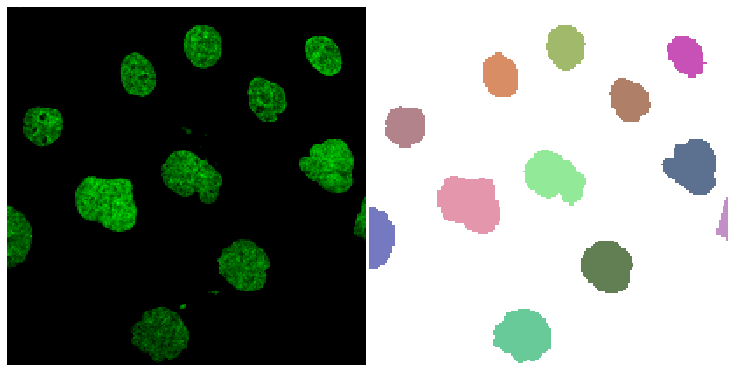

In [14]:
panel = Micropanel(1,2)
panel.add_element([0,0], microshow(im_nuclei[::10,::10], cmaps=['pure_green'], ax=panel.ax[0,0]));
panel.add_element([0,1], microshow(segmented[0], cmaps=['segmentation'], ax=panel.ax[0,1]));


## Using napari

Finally we can also visualize our data in napari, and make use of the very practical user interface to explore data:

In [15]:
import napari
import nest_asyncio
nest_asyncio.apply()

In [16]:
%gui qt

In [17]:
viewer = napari.Viewer()

2021-09-28 21:36:45,066 [INFO] No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'
2021-09-28 21:36:48,812 [INFO] Resource 'XMLSchema.xsd' is already loaded


In [18]:
viewer.add_image(im_nuclei[::10,::10], colormap='blue')
viewer.add_labels(segmented[0]);

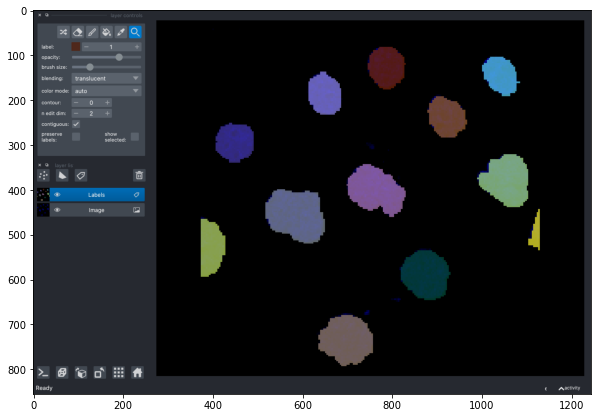

In [19]:
fig,ax=plt.subplots(figsize=(10,10))
ax.imshow(viewer.screenshot(canvas_only=False));